In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#chemin_fichier_excel = 'C:\\Users\\milos\\OneDrive\\Bureau\\M2\\Gestion quant\\projet KALMAN\\Appl_data.xlsx'
#df = pd.read_excel(chemin_fichier_excel)
#colonnes_selectionnees = ['Date', 'price'] 
#df_selection = df[colonnes_selectionnees]
#prix_apple=df['price']
#Dynamic State-Space Stochastic Volatility Model
class DDSSM :
    def __init__(self,N,T,p,mu,kappa,theta,xi,rho,S0=100,V0=0.20):
        # paramètre
        self.mu = mu
        self.kappa = kappa
        self.theta=theta
        self.xi = xi
        self.rho = rho
        self.N=N
        self.T=T
        self.p=p
        # Discrétisation temporelle
        dt = T / N
        # Génération de mouvements browniens corrélés
        #np.random.seed(42)
        self.Bt = np.random.normal(0, np.sqrt(dt), self.N)
        self.Zt = self.rho * self.Bt + np.sqrt(1 - self.rho**2) * np.random.normal(0, np.sqrt(dt), self.N)
        # Initialisation des vecteurs de prix et de volatilité
        self.S = np.zeros(N)
        self.V = np.zeros(N)
        self.logV=np.zeros(N)
        self.S[0]=S0
        self.S[1]=S0
        self.V[0]=V0
        self.V[1]=V0
        self.logV[0]=np.log10(V0)
        self.logV[1]=np.log10(V0)
        # Simulation du modèle 
        for i in range(2, self.N):
            self.logV[i] = np.log10(self.V[i-1]) + dt/self.V[i-1]*(self.kappa * (self.theta - self.V[i - 1]) - 1/2*self.xi**2*self.V[i-1]**(p-1) - self.rho*self.xi*self.V[i-1]**(p-0.5) * (self.mu[i-1] - 1/2*self.V[i-1])) + self.rho*self.xi*self.V[i-1]**(p-3/2)*(np.log(self.S[i-1]) - np.log(self.S[i-2])) + self.xi*self.V[i-1]**(p-1)*np.sqrt(dt)*np.sqrt(1-self.rho)*self.Zt[i-1] 
            self.V[i] = 10**self.logV[i]
            lnS = np.log(self.S[i-1]) + (self.mu[i-1] -self.V[i]/2)*dt + np.sqrt(dt)*np.sqrt(self.V[i])*self.Bt[i]
            self.S[i] = np.exp(lnS)

    def simulate(self):
        return self.V, self.S

    def disp(self):
        df = pd.DataFrame([self.S,self.V,self.Bt,self.Zt],index=['St','Vt','Bt','Zt']).T
        print(df)
        return
    
# Paramètres du modèle
N=252#len(prix_apple)
mu = [0.07 for i in range(N)]
kappa = 3
theta = 0.20
xi = 0.1
rho = -0.5
T=1
p=1/2 # Modèle de Heston
# Modèle 
H = DDSSM(N,T,p,mu,kappa,theta,xi,rho)
H.disp()
#print(mu)


             St        Vt        Bt        Zt
0    100.000000  0.200000  0.182350 -0.012414
1    100.000000  0.200000  0.116433  0.062051
2    100.182577  0.200377  0.068936  0.020848
3    100.247014  0.200207  0.027050  0.053273
4    100.052159  0.200435 -0.064737  0.127828
..          ...       ...       ...       ...
247   98.474431  0.198189  0.041262  0.010352
248   98.778014  0.198085  0.113900 -0.061399
249   98.834919  0.197184  0.024645  0.046223
250   98.855833  0.197444  0.011631  0.010968
251   98.893899  0.197460  0.017826 -0.011932

[252 rows x 4 columns]


C:\Users\milos\AppData\Local\Temp\ipykernel_8076\3271725172.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['vol'].iloc[0] = 0


0        0.000000
1        0.000780
2        0.000520
3        0.000223
4        0.000483
           ...   
13465    0.000073
13466    0.000073
13467    0.000073
13468    0.000036
13469    0.000218
Name: vol, Length: 13470, dtype: float64


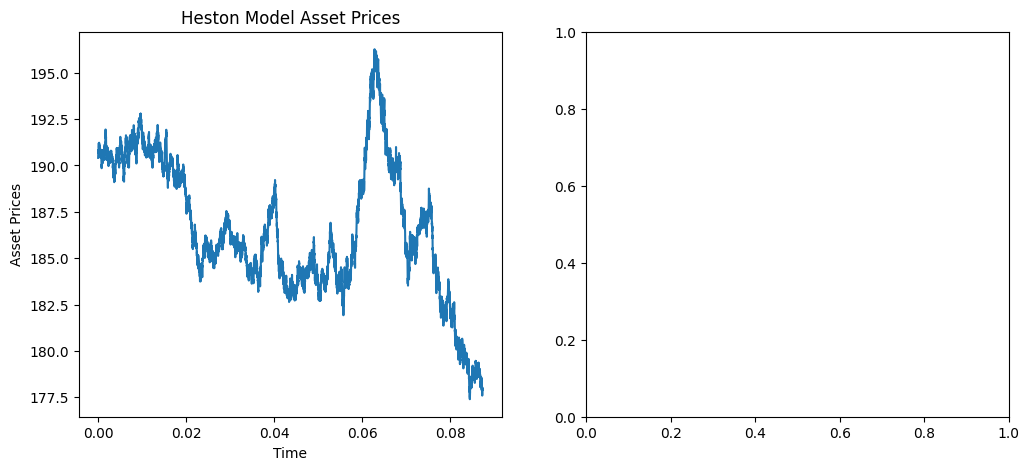

In [58]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize


S0 = 190.41            
T = 22/252               
r = 0.001               
N = 13470                
M = 1             

kappa = 3              
theta = 0.022        
v0 = 0.022          
rho = 0.7              
sigma = 0.6            

theta, v0

dff = pd.read_excel(r"C:\Users\milos\OneDrive\Bureau\M2\Gestion quant\projet KALMAN\Data_apple_ibm.xlsx",sheet_name="APPLE_1min")[["Date","Price"]] #sheet_name="Feuil3"
dff = dff.rename(columns={"Date": "t", "Price": "prices"})
dff.dropna(inplace=True)
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(2).std()
dff['vol'].iloc[0] = 0
print(dff['vol'])


def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):

    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)


    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)

    return S

rho_p = 0.3

S_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

#ax2.plot(time,S_p)
#ax2.set_title('Heston Model Variance Process')
#ax2.set_xlabel('Time')
#ax2.set_ylabel('Variance')

plt.show()





In [61]:
S0 = 190.41            
T = 22/252               
r = 0.001               
N = 13470                
M = 1
v0 = 0.022 

kappa_0 = 3              
theta_0 = 0.022                  
rho_0 = 0.7              
sigma_0 = 0.6            


initial_params = np.array([rho_0, kappa_0, theta_0, sigma_0])
observed_vol = dff["vol"].values
observed_prices=dff['prices'].values

def cost_function(parameters, *args):
    rho, kappa, theta, sigma = parameters
    S0, v0, T, N, M, r, observed_prices = args

    simulated_prices = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M)

    errors = simulated_prices[-1] - observed_prices

    cost = np.sum(errors**2)

    return cost


result = minimize(cost_function, initial_params, args=(S0, v0, T, N, M, r, observed_prices),method='L-BFGS-B')

rho_est, kappa_est, theta_est, sigma_est = result.x

print("Paramètres estimés:")
print("rho =", rho_est)
print("kappa =", kappa_est)
print("theta =", theta_est)
print("sigma =", sigma_est)


Paramètres estimés:
rho = 0.6999994697480071
kappa = 2.9999995946435187
theta = 0.021999913575929057
sigma = 0.5999999781118026


In [15]:
import yfinance as yf
import pandas as pd

# Définir le symbole d'Apple et les dates d'intérêt
symbol = "AAPL"
start_date = "2022-01-01"
end_date = "2023-01-01"

# Télécharger les données depuis Yahoo Finance
apple_data = yf.download(symbol, start=start_date, end=end_date)

# Sélectionner la colonne des prix de clôture (Close)
prices = apple_data['Close']

# Calculer les rendements quotidiens
returns = prices.pct_change().dropna()
# Calculer le rendement journalier moyen
daily_return = returns.mean()

# Calculer le rendement annuel moyen
annual_return = returns.mean() * 252  # 252 jours de trading par an

# Calculer la volatilité journalière
daily_volatility = returns.std()

# Calculer la volatilité sur 22 jours
rolling_volatility = returns.rolling(window=22).std()

# Calculer la valeur unique pour la volatilité sur 22 jours
volatility_22_days = rolling_volatility.mean()

# Afficher les résultats
print("Rendement journalier moyen du cours d'Apple:")
print(daily_return)

print("\nRendement annuel moyen du cours d'Apple:")
print(annual_return)

print("\nVolatilité journalière du cours d'Apple:")
print(daily_volatility)

print("\nVolatilité sur 22 jours du cours d'Apple (moyenne):")
print(volatility_22_days)





[*********************100%%**********************]  1 of 1 completed

Rendement journalier moyen du cours d'Apple:
-0.0010966302389079968

Rendement annuel moyen du cours d'Apple:
-0.2763508202048152

Volatilité journalière du cours d'Apple:
0.022470985769036427

Volatilité sur 22 jours du cours d'Apple (moyenne):
0.02235956049621863
